# Introduction to PyTorch on ROCm + OCR Example

This notebook provides a step-by-step guide to installing PyTorch for ROCm and building an OCR system
using vision-language models with the Hugging Face Transformers library. Gradio is also leveraged for a graphical user inference.
 
Optical Character Recognition (OCR) is essential for extracting text from images, scanned documents, and handwritten content.
Vision-language models (VLMs) enhance OCR by leveraging transformer-based architectures, enabling context-aware text recognition.
 
This tutorial explores how to use models like Phi-3 Vision for OCR. It covers the following topics:

1. [Environment starting point](#env-start)   
2. [Installing PyTorch](#install-pt)
3. [Installing dependencies for OCR example](#install-deps)
4. [Building an OCR application](#cli-ocr)  
5. [Adding a GUI with Gradio](#gradio-gui)


## Prerequisites

This tutorial was developed and tested on an Azure MI300X VM ([ND-MI300X-v5](https://learn.microsoft.com/en-us/azure/virtual-machines/sizes/gpu-accelerated/ndmi300xv5-series)) using the latest [Ubuntu-based HPC/AI](https://azuremarketplace.microsoft.com/en/marketplace/apps/microsoft-dsvm.ubuntu-hpc) image from Azure marketplace. 

### Operating system

* **Ubuntu 22.04**: Both the VM image and the docker image used in this tutorial are based on Ubuntu 22.04.

### Hardware

* **AMD Instinct™ GPUs**: This tutorial was tested on an AMD Instinct MI300X GPU. If not using an Azure ND-MI300X-v5 VM ensure that your system meets the [official requirements](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/reference/system-requirements.html).

### Software

* **ROCm 6.4**: The latest release of ROCm will be leveraged (6.4 at the time of this writing) by selecting a corresponding Docker image from the [ROCm Docker Hub](https://hub.docker.com/u/rocm).  If PyTorch is the only requirement typically a [rocm/pytorch](https://hub.docker.com/r/rocm/pytorch/tags) image would be used.  But for this tutorial we start from a clean slate [rocm/dev-ubuntu-22.04](https://hub.docker.com/r/rocm/dev-ubuntu-22.04/tags) Ubuntu image for the pupose of demonstrating the ease of installing PyTorch.  This Ubuntu image comes with ROCm pre-installed for developer use cases.


<a id="env-start"></a>
## 1. Environment starting point [for reference only]

This tutorial starts from a pre-configured Docker container mapped to a single GPU and with Jupyter Notebook already installed and running.  Use the lab provided URL to access the Juptyer Notebook interface and then proceed immediately to Step 2.  However, for reference and for those following this tutorial outside the original lab environment the following reference commands are provided to get to a similar starting point.

``` bash
docker run \
      -v /home/$USER:/workspace -w /workspace \
      --privileged --ipc=host --network=host --group-add video \
      --device=/dev/kfd --device=/dev/dri/renderD128 \
      -it rocm/dev-ubuntu-22.04:6.4-complete
```
The command above only maps a single GPU to the Docker container.  In this case the first GPU is mapped but this can be modified to select the desired GPU or changed to simply `/dev/dri` to map all GPUs.

From inside the running Docker container the tutorial is downloaded and Jupyter Notebook is installed and run.
``` bash
apt update
apt install -y git
git clone https://github.com/shaunpamd/gpuaidev.git
pip install jupyter
jupyter-lab --ip=0.0.0.0 --port=8888 --no-browser --allow-root
```
**Note**: Ensure port `8888` is not already in use on your system before running the above command. If it is, you can specify a different port by replacing `--port=8888` with another port number, for example, `--port=8890`.

<a id="install-pt"></a>
## 2. Installing PyTorch

Installing PyTorch for ROCm is easy and well documented.  A simply pip install can be extracted directly from the PyTorch site by selecting the desired build and choosing ROCm as the Compute Platform:
- [https://pytorch.org/get-started/locally/](https://pytorch.org/get-started/locally/)

Generally, you'd want to install the latest stable build but then you could miss out on the latest release of ROCm.  Since this tutorial was intended for a developer audience we'll opt to use the latest ROCm release along with the corresponding Preview/Nightly build of PyTorch.  From the PyTorch website you should see a recommendation such shown below.

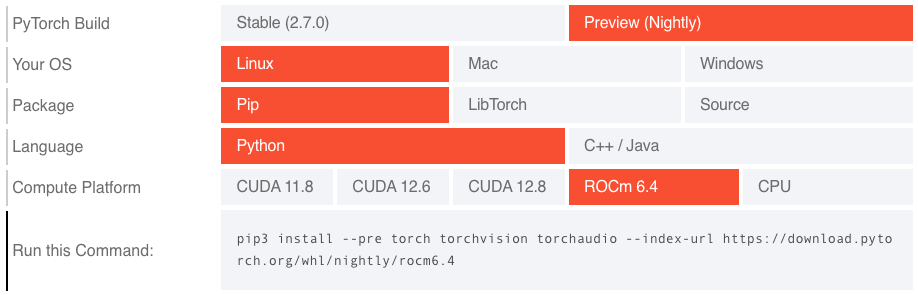

Perform the install by running the command below (will take a couple mins to complete).

In [ ]:
!pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/rocm6.4 --no-cache-dir

**NOTE:** Those with a keen eye may have noticed that we added the `--no-cache-dir` option to the pip install command provided by the PyTorch site.  This is only to accomodate the Docker container environment and would not be needed if installing outside a container.

Now that PyTorch is installed let's check that it can detect a GPU for acceleration.

In [ ]:
import torch
torch.cuda.is_available()

Wasn't that easy?

Of course, an API name change such as say `torch.accel.is_available()` or similar would have beed preferred under the context of this lab but as legacy has it we must interpret `cuda` here to represent the presence of accelerator support in general.  In this case PyTorch is confirming the presence of ROCm supported GPUs.

But how many GPUs do we have?  A simple tool `rocm-smi` can be used to list GPUs along with status of various fields.  Try it out below.

In [ ]:
!rocm-smi

Before we move on to more interesting stuff let's just check that we are indeed getting acceleration!

Run the code below to define a couple functions for measuring latency and performing a matrix multiplication operation with PyTorch.

In [ ]:
import torch
import time

def measure_latency(func, device, *args):
    start_event = torch.cuda.Event(enable_timing=True) if device == 'cuda' else None
    end_event = torch.cuda.Event(enable_timing=True) if device == 'cuda' else None

    if device == 'cuda':
        start_event.record()
    start_time = time.time()
    
    func(*args)
    
    end_time = time.time()
    if device == 'cuda':
        end_event.record()
        torch.cuda.synchronize()  # Wait for the GPU to finish
        latency_ms = start_event.elapsed_time(end_event)
    else:
        latency_ms = (end_time - start_time) * 1000
    return latency_ms

def matrix_multiply(a, b):
    return torch.matmul(a, b)

Now run the code below to check the latency of doing this operation on CPU vs GPU.  Feel free to adjust the size of the matrix operation.

In [ ]:
size = 8192
a_cpu = torch.rand(size, size)
b_cpu = torch.rand(size, size)

if torch.cuda.is_available():
    a_gpu = a_cpu.cuda()
    b_gpu = b_cpu.cuda()

# warm-up
matrix_multiply(a_cpu, b_cpu)
cpu_latency = measure_latency(matrix_multiply, 'cpu', a_cpu, b_cpu)
print(f"CPU Latency: {cpu_latency:.4f} ms")

if torch.cuda.is_available():
    # warm-up
    matrix_multiply(a_gpu, b_gpu)
    gpu_latency = measure_latency(matrix_multiply, 'cuda', a_gpu, b_gpu)
    print(f"GPU Latency: {gpu_latency:.4f} ms")
else:
     print("CUDA is not available. Skipping GPU test.")

Pretty nice acceleration right?

Now that we have the basics out of the way let's end with something a bit more interesting.  For the remaining sections we will develop a simple OCR application that leverages a transformer vision model.

<a id="install-deps"></a>
## 3. Installing dependencies for OCR example

Install the Python packages needed for this tutorial.  Specific versions are selected to correspond to a pre-validated environment but, in general, you should be able to install the latest version of each of these.

In [ ]:
!pip install transformers==4.47.1 accelerate==1.6.0 gradio==5.29.0

<a id="cli-ocr"></a>
## 4. Building an OCR application

First, define the `ImageInference` inference class. This class provides a constructor to initialize a model for inference. Additionally, it defines another function that runs inference on an image that you provide. 

In [ ]:
from PIL import Image 
import requests 
from transformers import AutoModelForCausalLM 
from transformers import AutoProcessor

#model_id = "microsoft/Phi-3-vision-128k-instruct"
model_id = "microsoft/Phi-3.5-vision-instruct"

class ImageInference:
    def __init__(self, model_name=model_id):
        # Initialize the model and processor
        self.model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cuda:0", trust_remote_code=True, torch_dtype="auto", _attn_implementation='eager')
        self.processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
    
    def generate_image_output(self, image) -> str:
        messages = [{
            'role': 'user',
            'content': (
                "Act as an OCR assistant. Analyze the provided <|image_1|> image and:\n"
                "1. Identify and transcribe all visible text in the image exactly as it appears.\n"
                "2. Preserve the original line breaks, spacing, and formatting from the image.\n"
                "3. Output only the transcribed text, line by line, without adding any commentary or explanations or special characters.\n"
            )
        }]
        
        #url = "https://raw.githubusercontent.com/ROCm/gpuaidev/main/docs/notebooks/assets/together_we_advance_.png" 
        #image = Image.open(requests.get(image_url, stream=True).raw) 
        
        prompt = self.processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        
        inputs = self.processor(prompt, [image], return_tensors="pt").to("cuda:0") 
        
        generation_args = { 
            "max_new_tokens": 500, 
            "do_sample": False, 
        } 
        
        generate_ids = self.model.generate(**inputs, eos_token_id=self.processor.tokenizer.eos_token_id, **generation_args) 
        
        # remove input tokens 
        generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
        response = self.processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0] 

        return response

### Testing the OCR system

To test our new class we'll feed it the following image:

<img src="https://raw.githubusercontent.com/ROCm/gpuaidev/main/docs/notebooks/assets/together_we_advance_.png" alt="AMD slogan">

Just run the code below to test it out.

In [ ]:
url = "https://raw.githubusercontent.com/ROCm/gpuaidev/main/docs/notebooks/assets/together_we_advance_.png"

# open test image
image = Image.open(requests.get(url, stream=True).raw) 

# Initialize the inference class
inference = ImageInference()
# Generate output for the image
output = inference.generate_image_output(image)

# Print the result
print("Model Output:")
print(output)

Congratulations. You've just built an OCR application. That's how simple it is to create an OCR-like system that transcribes the text in a given image.

Please run the garbage collection below to free up GPU memory before proceeding.  There's also an optional section below that adds a GUI to the OCR.  It's provided as reference material or you can return to it after completing the next lab on Agentic AI.

In [ ]:
import torch, gc

del inference
gc.collect()
torch.cuda.empty_cache() 

<a id="gradio-gui"></a>
## 5. Adding a GUI with Gradio [For Reference Only]

To provide a graphical interface for your application, use [Gradio](https://www.gradio.app/) to create an interactive web-based UI.

### Import Gradio and define a list of VLM models to access 

You're going to create a shortlist of handpicked models that can analyze images.



In [ ]:
import gradio as gr

# Define available models and their Hugging Face model IDs
MODEL_OPTIONS = {
    "BLIP-2 (2.7B)": "Salesforce/blip2-opt-2.7b",
    "Phi-3 Vision (128K)": "microsoft/Phi-3-vision-128k-instruct",
    "Phi-3.5 Vision": "microsoft/Phi-3.5-vision-instruct",
    "Qwen2-VL (2B)": "Qwen/Qwen2-VL-2B-Instruct",
}

### Create the Gradio interface

Next, define two simple helper functions for switching models and running inference using your previously defined class, followed by Gradio blocks:

In [ ]:
def switch_model(model_name):
    global inference
    try:
        inference = ImageInference(model_name=model_name)
        return f"Switched to model: {model_name}"
    except Exception as e:
        return f"Failed to switch model: {str(e)}"

def analyze_image(image):
    try:
        pil_image = image.convert("RGB")
        result = inference.generate_image_output(image)
        return result
    except Exception as e:
        return f"Error processing the image: {str(e)}"

with gr.Blocks() as interface:
    gr.Markdown("## Multimodal OCR & Image Analysis")
    
    with gr.Row():
        model_dropdown = gr.Dropdown(
            choices=list(MODEL_OPTIONS.keys()),
            value="Phi-3 Vision (128K)",
            label="Select Model",
        )
        switch_button = gr.Button("Switch Model")

    model_status = gr.Textbox(value=f"Current Model: {model_id}", label="Model Status")

    image_input = gr.Image(type="pil", label="Upload Image")
    #url_input = gr.Textbox(label="Image URL", lines=1)
    analyze_button = gr.Button("Analyze Image")
    # output_box = gr.Textbox(label="Model Output", lines=10)
    output_box = gr.Markdown(label="Model Output")

    switch_button.click(
        fn=lambda selected_model: (switch_model(MODEL_OPTIONS[selected_model]), f"Current Model: {MODEL_OPTIONS[selected_model]}"),
        inputs=[model_dropdown],
        outputs=[model_status, model_status],
    )
    analyze_button.click(fn=analyze_image, inputs=image_input, outputs=output_box)


### Run the Gradio application

Execute the code block below to launch the GUI. The interface displays in your browser, letting you interact with the OCR system.

Here's a selection of logos you can download to try: [https://commons.wikimedia.org/wiki/Category:Logos_of_organizations](https://commons.wikimedia.org/wiki/Category:Logos_of_organizations)

Or some posters: [https://commons.wikimedia.org/wiki/Category:Posters_in_Wikimedia_Hackathon_Prague_2019](https://commons.wikimedia.org/wiki/Category:Posters_in_Wikimedia_Hackathon_Prague_2019)

In [ ]:
interface.launch(share=True)


## Conclusion

In this tutorial, you accomplished the following tasks:

* Installed PyTorch for ROCm with ease.
* Built an OCR application using the Hugging Face Transformers library.
* Extended the OCR application by adding a GUI and a selection of multiple different models.
